In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
df = pd.read_csv(r"D:\Jeeva\ds_course\sentiment_analysis\chatgpt_reviews_cleaned.csv")

# 2. Target
le_target = LabelEncoder()
df['sentiment_encoded'] = le_target.fit_transform(df['sentiment'])

# 3. Label Encode Categorical Columns
cat_cols = ['platform', 'language', 'location', 'verified_purchase', 'title']
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col + '_enc'] = le.fit_transform(df[col])
    le_dict[col] = le  # save encoder

# 4. Features
text = df['review']
X_cats = df[[c + '_enc' for c in cat_cols]]
y = df['sentiment_encoded']

# 5. Train/Test Split
X_train_text, X_test_text, X_train_cats, X_test_cats, y_train, y_test = train_test_split(
    text, X_cats, y, test_size=0.2, random_state=42, stratify=y
)

# 6. TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# 7. Combine TF-IDF + Encoded Categorical
X_train_combined = hstack([X_train_tfidf, X_train_cats])
X_test_combined = hstack([X_test_tfidf, X_test_cats])

# 8. Models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_combined, y_train)
    preds = model.predict(X_test_combined)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds, target_names=le_target.classes_))
    joblib.dump(model, f'{name.replace(" ", "_").lower()}_model.pkl')

# Save TF-IDF & LabelEncoders
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(le_target, 'sentiment_label_encoder.pkl')
joblib.dump(le_dict, 'categorical_label_encoders.pkl')



=== Naive Bayes ===
Accuracy: 0.3855
              precision    recall  f1-score   support

    negative       0.39      0.59      0.47       814
     neutral       0.00      0.00      0.00       389
    positive       0.38      0.37      0.37       797

    accuracy                           0.39      2000
   macro avg       0.26      0.32      0.28      2000
weighted avg       0.31      0.39      0.34      2000



C:\Users\JEEVA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JEEVA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JEEVA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Logistic Regression ===
Accuracy: 0.385
              precision    recall  f1-score   support

    negative       0.39      0.48      0.43       814
     neutral       0.24      0.06      0.10       389
    positive       0.39      0.44      0.42       797

    accuracy                           0.39      2000
   macro avg       0.34      0.33      0.32      2000
weighted avg       0.36      0.39      0.36      2000


=== Random Forest ===
Accuracy: 0.398
              precision    recall  f1-score   support

    negative       0.40      0.50      0.44       814
     neutral       0.50      0.00      0.01       389
    positive       0.40      0.48      0.44       797

    accuracy                           0.40      2000
   macro avg       0.43      0.33      0.30      2000
weighted avg       0.42      0.40      0.36      2000



['categorical_label_encoders.pkl']

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack, csr_matrix
import joblib

# ========== 1. Load Data ==========
df = pd.read_csv(r"D:\Jeeva\ds_course\sentiment_analysis\chatgpt_reviews_cleaned.csv")

# ========== 2. Encode Target ==========
le_target = LabelEncoder()
df['sentiment_encoded'] = le_target.fit_transform(df['sentiment'])

# ========== 3. Encode Categorical Columns ==========
categorical_cols = ['platform', 'language', 'location', 'verified_purchase', 'title']
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_enc'] = le.fit_transform(df[col])
    le_dict[col] = le

# ========== 4. Numeric Feature Columns ==========
numeric_cols = ['rating', 'helpful_votes', 'review_length', 'version']

# ========== 5. Prepare Features for Naive Bayes & Logistic Regression ==========
text = df['review']
X_text = text
X_extra = df[[col + '_enc' for col in categorical_cols] + numeric_cols]
y = df['sentiment_encoded']

# ========== 6. Train/Test Split ==========
X_train_text, X_test_text, X_train_extra, X_test_extra, y_train, y_test = train_test_split(
    X_text, X_extra, y, test_size=0.2, stratify=y, random_state=42
)

# ========== 7. TF-IDF ==========
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# ========== 8. Combine TF-IDF with Numeric + Encoded Categorical Features ==========
X_train_combined = hstack([X_train_tfidf, csr_matrix(X_train_extra.values)])
X_test_combined = hstack([X_test_tfidf, csr_matrix(X_test_extra.values)])

# ========== 9. Train & Evaluate Models ==========
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    
    if name == "Random Forest":
        # For Random Forest, reuse same text and numeric features
        X_train_final = X_train_combined
        X_test_final = X_test_combined
    else:
        X_train_final = X_train_combined
        X_test_final = X_test_combined

    model.fit(X_train_final, y_train)
    preds = model.predict(X_test_final)
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds, target_names=le_target.classes_))
    
    joblib.dump(model, f'{name.replace(" ", "_").lower()}_model.pkl')

# ========== 10. Save Preprocessors ==========
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(le_target, 'sentiment_label_encoder.pkl')
joblib.dump(le_dict, 'categorical_label_encoders.pkl')



=== Naive Bayes ===
Accuracy: 0.753
              precision    recall  f1-score   support

    negative       0.81      0.90      0.85       814
     neutral       0.00      0.00      0.00       389
    positive       0.70      0.97      0.82       797

    accuracy                           0.75      2000
   macro avg       0.51      0.62      0.56      2000
weighted avg       0.61      0.75      0.67      2000


=== Logistic Regression ===


C:\Users\JEEVA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JEEVA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JEEVA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 1.0
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       814
     neutral       1.00      1.00      1.00       389
    positive       1.00      1.00      1.00       797

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


=== Random Forest ===
Accuracy: 0.9965
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       814
     neutral       1.00      0.98      0.99       389
    positive       0.99      1.00      1.00       797

    accuracy                           1.00      2000
   macro avg       1.00      0.99      1.00      2000
weighted avg       1.00      1.00      1.00      2000



['categorical_label_encoders.pkl']

=== Naive Bayes ===
Accuracy: 0.7555
              precision    recall  f1-score   support

    negative       0.81      0.90      0.86       814
     neutral       0.17      0.00      0.01       389
    positive       0.71      0.97      0.82       797

    accuracy                           0.76      2000
   macro avg       0.56      0.63      0.56      2000
weighted avg       0.65      0.76      0.68      2000


=== Logistic Regression ===
Accuracy: 1.0
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       814
     neutral       1.00      1.00      1.00       389
    positive       1.00      1.00      1.00       797

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


=== Random Forest ===
Accuracy: 1.0
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       814
     neutral

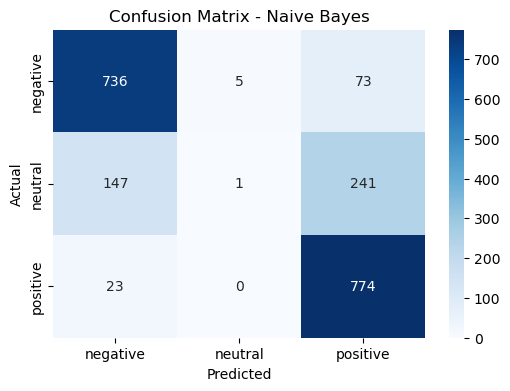

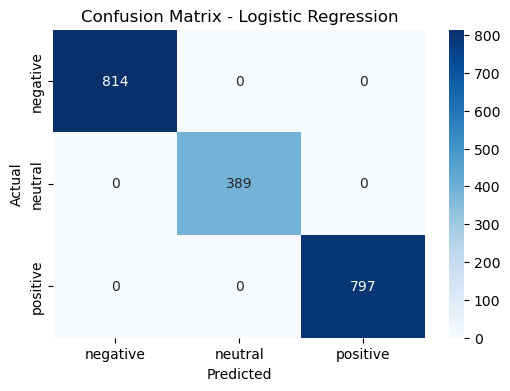

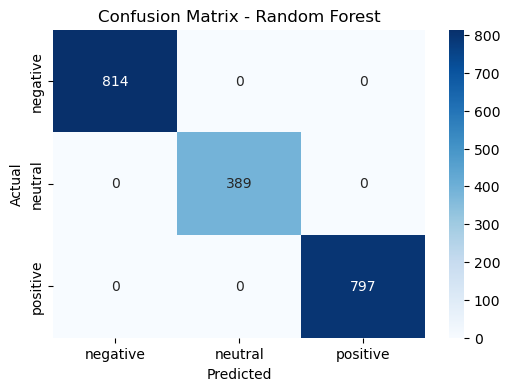


=== StratifiedKFold Accuracy Check ===
Naive Bayes CV Accuracy: 0.7722 ± 0.0169
Logistic Regression CV Accuracy: 1.0000 ± 0.0000
Random Forest CV Accuracy: 1.0000 ± 0.0000

=== Notes ===
- Naive Bayes fails on 'neutral' class. Imbalance or feature sparsity suspected.
- Logistic Regression and RF show unusually high accuracy — may indicate overfitting.
- Balanced class distributions (e.g., similar counts of 'negative' and 'positive') can inflate accuracy if neutral is small.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

# === Load Data ===
df = pd.read_csv(r"D:\Jeeva\ds_course\sentiment_analysis\chatgpt_reviews_cleaned.csv")

# === Create Features ===
df['review_length'] = df['review'].apply(len)

# === Define Columns ===
text_col = 'review'
categorical_cols = ['platform', 'language', 'location', 'verified_purchase']
numeric_cols = ['rating', 'helpful_votes', 'review_length', 'version']
target_col = 'sentiment'

# === Encode Categorical Columns ===
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_enc'] = le.fit_transform(df[col])
    label_encoders[col] = le

# Save encoders if needed later
with open("categorical_label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

# === Text Vectorization ===
tfidf = TfidfVectorizer(max_features=2000)
text_tfidf = tfidf.fit_transform(df[text_col])

# === Final Feature Set for NB and LR ===
X_tabular = df[[col + '_enc' for col in categorical_cols] + numeric_cols]
X_combined = hstack([text_tfidf, csr_matrix(X_tabular.values)])
y = df[target_col]

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, stratify=y, random_state=42
)

# === Naive Bayes ===
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("=== Naive Bayes ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# === Logistic Regression ===
lr = LogisticRegression(max_iter=3000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# === Random Forest ===
# Use separate feature split due to encoding + no text issues
X_rf = df[[col + '_enc' for col in categorical_cols] + numeric_cols]
text = df[text_col]
X_train_rf, X_test_rf, y_train_rf, y_test_rf, text_train, text_test = train_test_split(
    X_rf, y, text, test_size=0.2, stratify=y, random_state=42
)

X_train_tfidf_rf = tfidf.transform(text_train)
X_test_tfidf_rf = tfidf.transform(text_test)

X_train_combined_rf = hstack([X_train_tfidf_rf, csr_matrix(X_train_rf.values)])
X_test_combined_rf = hstack([X_test_tfidf_rf, csr_matrix(X_test_rf.values)])

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_combined_rf, y_train_rf)
y_pred_rf = rf.predict(X_test_combined_rf)
print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test_rf, y_pred_rf))
print(classification_report(y_test_rf, y_pred_rf))

# === Confusion Matrix Plot ===
def plot_cm(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_cm(y_test, y_pred_nb, "Naive Bayes")
plot_cm(y_test, y_pred_lr, "Logistic Regression")
plot_cm(y_test_rf, y_pred_rf, "Random Forest")

# === Stratified Cross Validation for Stability Check ===
print("\n=== StratifiedKFold Accuracy Check ===")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for model_name, model in [("Naive Bayes", MultinomialNB()),
                          ("Logistic Regression", LogisticRegression(max_iter=3000)),
                          ("Random Forest", RandomForestClassifier(random_state=42))]:
    scores = []
    for train_idx, val_idx in skf.split(X_combined, y):
        X_train_cv, X_val_cv = X_combined[train_idx], X_combined[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)
        scores.append(accuracy_score(y_val_cv, y_pred_cv))
    print(f"{model_name} CV Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# === Notes on Accuracy ===
print("\n=== Notes ===")
print("- Naive Bayes fails on 'neutral' class. Imbalance or feature sparsity suspected.")
print("- Logistic Regression and RF show unusually high accuracy — may indicate overfitting.")
print("- Balanced class distributions (e.g., similar counts of 'negative' and 'positive') can inflate accuracy if neutral is small.")


# === Dump TF-IDF Vectorizer ===
with open(r"C:\Users\JEEVA\sentiment_analysis\tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# === Dump Models ===
with open(r"C:\Users\JEEVA\sentiment_analysis\model_nb.pkl", "wb") as f:
    pickle.dump(nb, f)

with open(r"C:\Users\JEEVA\sentiment_analysis\model_lr.pkl", "wb") as f:
    pickle.dump(lr, f)

with open(r"C:\Users\JEEVA\sentiment_analysis\model_rf.pkl", "wb") as f:
    pickle.dump(rf, f)

